In [67]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.colors as colors

In [31]:
# 2/3D vec,tor classes with basic operations
class Vector2:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, other):
        return Vector2(self.x + other.x, self.y + other.y)
    
    def __sub__(self, other):
        return Vector2(self.x - other.x, self.y - other.y)
    
    def __mul__(self, other: float):
        return Vector2(self.x * other, self.y * other)
    
    def __truediv__(self, other: float):
        return Vector2(self.x / other, self.y / other)
class Vector3:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __add__(self, other):
        return Vector3(self.x + other.x, self.y + other.y, self.z + other.z)
    
    def __sub__(self, other):
        return Vector3(self.x - other.x, self.y - other.y, self.z - other.z)
    
    def __mul__(self, other):
        return Vector3(self.x * other, self.y * other, self.z * other)
    
    def __truediv__(self, other):
        return Vector3(self.x / other, self.y / other, self.z / other)

    def __repr__(self):
         return f"Vector3({self.x}, {self.y}, {self.z})"

In [76]:
# a workpiece is cylinder defined by its length and radius
class Workpiece:
    def __init__(self, length: int, radius: float):
        self.length = length
        self.radius = radius
        self.array = []
        for i in range(0, length):
            self.array.append(self.radius)
    
    # sets the correct dimensions of the plot and plots the workpiece
    def visualize(self):
        """
        x = np.array([i for i in range(self.length)])
        b_spline_coeff = make_interp_spline(x, self.array)
        x_final = np.linspace(x.min(), x.max(), 500)
        y_final = b_spline_coeff(x_final)
        plt.plot(x_final, y_final)
        """
        plt.plot(self.array, color='orange')
        plt.xlim(0, self.length)
        plt.ylim(0, self.radius * 2)

    # point is the index of the slice, depth the y-coordinate of the cut
    def cut(self, point: int, depth: float):
        self.array[point] = depth

    # cut to the same depth at multiple points
    # points: (from: inclusive, to: exclusive)
    def cut_multiple(self, points: list[int, int], depth: float):
        for point in range(points[0], points[1] - 1):
            self.cut(point, depth)

In [182]:
# position is left top corner
# form is a list of tuples with float (depth) and int (how often) (index is x-coordinate, value is cut-depth)
# wp_lenght is the length of the workpiece, needed for correct plotting
class Tool:
    def __init__(self, position: Vector2, raw_form: list[tuple()], wp_lenght: int, interpolate: bool = True):
        self.position = position
        self.raw_form = self.set_raw_form(raw_form, interpolate)
        self.wp_lenght = wp_lenght
        self.form = self.calculate_form()


    def set_raw_form(self, raw_form, interpolate):
        local_raw_form = []
        modified_raw_form = []
        modified_raw_form.append([0, 0])
        
        # loop over every tuple in the list
        for i in range(len(raw_form)):
            for element in raw_form:
                modified_raw_form[-1][1] = int(element[1] / 1)
                modified_raw_form.append([element[0], int(element[1] / 2)])

            # loop over every point in between the two given points
            for j in range(modified_raw_form[i][1]):
                if interpolate:
                    try:
                        # interpolate between the two points with the given offsets
                        x0 = modified_raw_form[i][0]
                        x1 = modified_raw_form[i + 1][0]
                        step = (x1 - x0) / (modified_raw_form[i][1] + 1)  # Include both endpoints
                        local_raw_form.append(x0 + step * j)
                    except IndexError:
                        print("error")
                else:
                    # just add the current point
                    local_raw_form.append(raw_form[i][0])
        
        return local_raw_form




    # moves the tool by the given vector and recalculates the form
    def move(self, movement: Vector2):
        self.position += movement
        self.form = self.calculate_form()

    # after this function plt.show() must be called seperately (in this way so we can plot a workpiece and a tool in the same plot)
    def visualize(self, wp):
        """
        x = np.array([i for i in range(self.wp_lenght)])
        b_spline_coeff = make_interp_spline(x, self.calculate_form())
        x_final = np.linspace(x.min(), x.max(), 500)
        y_final = b_spline_coeff(x_final)
        """
        plt.plot(self.calculate_form(), color='blue')
        plt.xlim(0, self.wp_lenght)
        plt.ylim(0, wp.radius * 2)
    
    # must be called after every change to the positition
    def calculate_form(self):
        local_form = self.raw_form.copy()
        for i in range(0, self.position.x): local_form.insert(0, 0)
        for i, _ in enumerate(local_form): local_form[i] = self.position.y - local_form[i]
        while len(local_form) < self.wp_lenght: local_form.append(self.position.y)
        
        return local_form.copy()
    
    # cut the workpiece if the tool is below the surface
    def cut(self, wp: Workpiece):
        for i, _ in enumerate(wp.array):
            if self.form[i] < wp.array[i]: wp.cut(i, self.form[i])

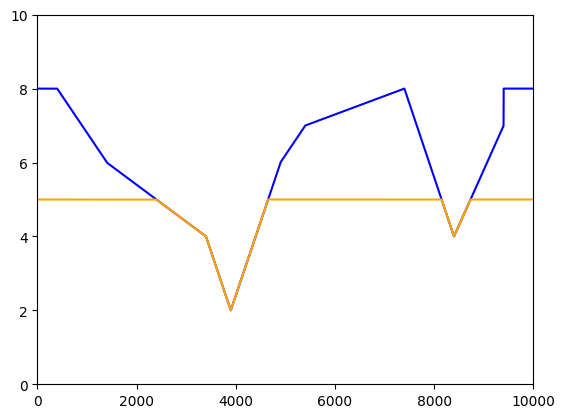

In [192]:
# intialize workpiece with length 50, (this is the number of slices) and radius 5
wp = Workpiece(10000, 5)

# intialize the tool at the given position and set the shape
tl = Tool(Vector2(400, 8), [(1, 500), (2, 500), (4, 2000), (6, 500), (4, 500), (2, 500), (1, 500), (0, 2000), (4, 1000), (1, 1000)], wp.length)

tl.visualize(wp)
# cut out the parts of the workpiece that are in contact with the tool
tl.cut(wp)

# plot the workpiece and the tool and show the plot
#tl.visualize()
wp.visualize()
plt.show()

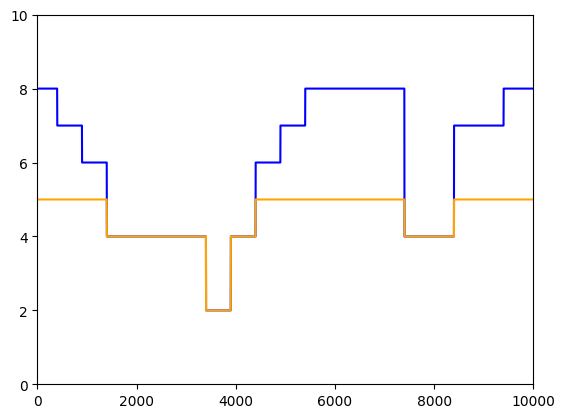

In [194]:
# intialize workpiece with length 50, (this is the number of slices) and radius 5
wp = Workpiece(10000, 5)

# intialize the tool at the given position and set the shape
tl = Tool(Vector2(400, 8), [(1, 500), (2, 500), (4, 2000), (6, 500), (4, 500), (2, 500), (1, 500), (0, 2000), (4, 1000), (1, 1000)], wp.length, False)

tl.visualize(wp)
# cut out the parts of the workpiece that are in contact with the tool
tl.cut(wp)

# plot the workpiece and the tool and show the plot
#tl.visualize()
wp.visualize()
plt.show()